# load in data, extract, first filtering of PPseq spikes

178_1_7_run_1207023_1350
LOADING PPSEQ DATA


      done


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [[8300, 10000], [10500, 11200], [13300, 14300]]


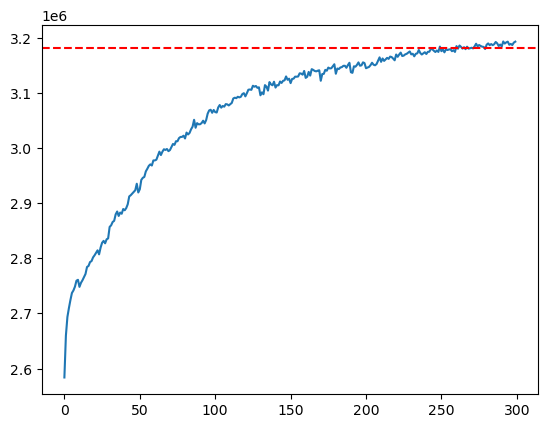

100%|██████████| 693758/693758 [01:49<00:00, 6358.78it/s]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45580\835674682.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked_

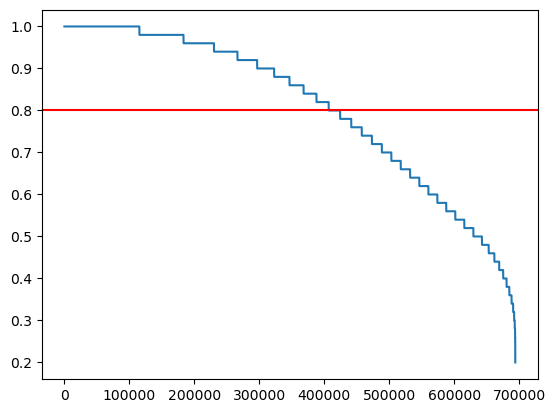

In [ ]:
from Utilities.utils import *

current_working_dir = os.path.join(Path(os.getcwd()).parent,'data') 
PP_PATH = current_working_dir + r'\preproc\Sleep\\'
pp_file = '178_1_7_run_1207023_1350'


######################################################################################################################################################################################################################

mir = '_'.join(pp_file.split('_')[0:3])
print(pp_file)
mouse_session_recording = pp_file.split('_')[0] + '_' + pp_file.split('_')[1] + '_' + pp_file.split('_')[2] 

## load in PPseq output data
assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_time_interval_start = load_PPSEQ_data(PP_PATH,pp_file,mir)

    # behav_sync = pd.read_csv(behav_sync_path + 'Behav_Ephys_Camera_Sync.csv')
    # transitions = pd.read_csv(behav_sync_path + 'Transition_data_sync.csv')

# plot out log l curve 
plot_save_log_l_curve(log_p_hist_df)

# ---filter_across_itterations---------------------------------------------------------------------------------------------------------------------------------------------------------------    
# Initialize an empty df to store the result
seq_types_df = pd.DataFrame()
# Iterate through the range
# for iteration_ in tqdm(range(400, 500)):
for iteration_ in tqdm(range(250, 300)):
    # Extract the relevant column from the assignment history dataframe
    assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]
    # Get the index of the -1 split markers in the latent event history dataframe
    end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
    # Extract the relevant portion of the latent event history dataframe
    latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]
    # Create a dictionary from the dataframe for faster lookups
    df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()
    # Match the sequence ID to the sequence type
    seq_type = find_corresponding(assignment_history_df_split,df_dict)
    # Append the result to the df
    seq_types_df[str(iteration_+1)] = seq_type
proportion = []
seq_type = []
for index in tqdm(range(len(seq_types_df))):
    row = seq_types_df.loc[index]
    seq_type += [statistics.mode(row)] 
    proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]
# add seq type to dataframe
unmasked_spikes_df['sequence_type'] = seq_type
# add seq type to dataframe
unmasked_spikes_df['seq_confidence'] = proportion

# ## filter for background confidence :-------------------------------------------------------------------------------------------------------------------------------------------------------------------    
thresh = max(proportion) *.80 ### 
plt.plot(np.sort(proportion)[::-1])
plt.axhline(y = thresh, color = 'r', linestyle = '-')
unmasked_spikes_df['sequence_type_adjusted'] = seq_type
unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked_spikes_df.seq_confidence < thresh)[0]] = -1

## load in colors and order from awake data analysis -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
ordered_preferred_type = pd.read_pickle(os.path.join(PP_PATH,pp_file) + r'\analysed\ordered_preferred_type')
neuron_index = pd.read_pickle(os.path.join(PP_PATH,pp_file) + r'\analysed\neuron_index')
colors = pd.read_pickle(os.path.join(PP_PATH,pp_file) + r'\analysed\colors')
spikes_df = unmasked_spikes_df.copy()
colors += ['pink','lightblue', 'k'] 

############### plot simple rasters ------------------------------
interval_end_points,neuron_order = plot_data_raster(behav_time_interval_start, spikes_df, neuron_index, colors)

######################################################################################################################################################################################################################
# inital crude filtering of replays 
# spikes for each type are binned 
# if spikes occur continuously across bins then this is classified as a single contiguous replay event 


chunk_paths = []
# run for each time chunk: 
for index_,interval_start in enumerate([0] + list(interval_end_points)[0:-1]):

    ## save out time interval for current chunk:
    timeframe = [interval_start,interval_end_points[index_]-1]
    total_time = np.diff(timeframe)[0]+1
    #mask
    # spikemask for plotting
    mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])

    fig, [ax1,ax2] = plt.subplots(2, 1,figsize=(15, 6))

    # plot spikes without background
    background_remove_mask = (spikes_df[mask].sequence_type_adjusted > -1) * (spikes_df[mask].sequence_type_adjusted < 7)
    c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
    ax1.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)

    # define chunk data:
    chunk_mask = (spikes_df.timestamp > interval_start) * (spikes_df.timestamp < interval_end_points[index_])
    chunk_df = spikes_df[chunk_mask].copy()
    chunk_df = chunk_df.reset_index(drop=True)

    ### bin the spiking for each seq type
    bin_size = 0.02
    seqs = np.unique(chunk_df.sequence_type_adjusted)
    seq_spikes = []
    seq_neurons = []
    for seq_type_ in seqs:  
        seq_spikes += [chunk_df.timestamp[np.where(chunk_df.sequence_type_adjusted ==seq_type_)[0]].values]
        seq_neurons += [chunk_df.neuron[np.where(chunk_df.sequence_type_adjusted ==seq_type_)[0]].values]
    binned_seq_r_events = []
    for spikes_ in seq_spikes:
        # Use the numpy.histogram function to bin the data
        hist, bins = np.histogram(spikes_, bins=np.arange(interval_start, interval_end_points[index_], bin_size))
        binned_seq_r_events += [list(hist)]
    strt_ = int(timeframe[0]/bin_size)
    end_ = int(timeframe[1]/bin_size)   

    # loop over smoothed data for eeahc sew and create cluster chunks from this: 
    r_start_ = []
    r_end_ = []
    r_seq_type = []
    for _index_,sequence_type in enumerate(seqs):
        sequence_type = int(sequence_type)
        # if seq type not background or other new types:
        if sequence_type > 0 and sequence_type <= 6:
            print(sequence_type)

            # smooth over binned spikes:
            smoothed_binned_spikes = convolve_movmean(binned_seq_r_events[_index_],2)

            # plot smoothed counts for this sequence 
            time_bins = np.arange(timeframe[0],timeframe[0]+np.diff(timeframe)+1,bin_size)
            ax2.plot(time_bins[0:-1],smoothed_binned_spikes, c = colors[sequence_type])
            ax2.sharex(ax1)

            ## split smoothed replay into single events
            replay_chunks,indices = seperate_lists(list(smoothed_binned_spikes))

            for index,chunk in enumerate(replay_chunks):
                # start and end of chunk event:
                r_seq_type += [sequence_type]
                r_start_ += [time_bins[indices[index][0]]]
                r_end_ += [time_bins[indices[index][-1]]]

    filtered_r_clusters_df = filter_cluster_chunks(r_seq_type,r_start_,r_end_,chunk_df,neuron_order,chunk_mask,colors,ax1)
    
    ax1.set_xlim(timeframe[0]+140,timeframe[0]+144)
    ax2.set_xlim(timeframe[0]+140,timeframe[0]+144)
    plt.show()
    
######################################################################################################################################################################################################################
# cluster these events into coactive chunks

#cluster events
start_times = filtered_r_clusters_df.first_spike_time.values
end_times = filtered_r_clusters_df.last_spike_time.values
event_proximity_filter =  0.2 #s (how close events have to be to each other to be clustered together as coacitve 

clustered_events = cluster_events(start_times, end_times,event_proximity_filter)


spike_times = [item for sublist in filtered_r_clusters_df.cluster_spike_times.values for item in sublist]    
neuron_orders = [item for sublist in filtered_r_clusters_df.spike_plotting_order.values for item in sublist]    

cst = []
for index,item in enumerate(filtered_r_clusters_df.cluster_spike_times):
    cst += len(item)*[filtered_r_clusters_df.cluster_seq_type.values[index]]
c_ = np.array(colors)[np.array(cst)]
fig, [ax1,ax2] = plt.subplots(2, 1,figsize=(20, 10))

ax1.scatter(spike_times, neuron_orders,marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)
ax2.scatter(spike_times, neuron_orders,marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)

for i in range(len(start_times)):
    ax1.axvspan(start_times[i],end_times[i],color = colors[filtered_r_clusters_df.cluster_seq_type.values[i]],alpha = 0.2)

for cluster in clustered_events:
    starts = []
    ends = []
    for item in cluster:
        starts += [filtered_r_clusters_df.first_spike_time[item]]
        ends += [filtered_r_clusters_df.last_spike_time[item]]
    ax2.axvspan(min(starts),max(ends),color = 'grey' ,alpha = 0.2)

ax1.set_title('single R events')
ax2.set_title('co-ative R event groups')
ax1.set_xlim(timeframe[0]+60,timeframe[0]+90)
ax2.set_xlim(timeframe[0]+60,timeframe[0]+90)

cluster_group = np.zeros(len(filtered_r_clusters_df))
for index,cluster in enumerate(clustered_events):
    for item in cluster:
        cluster_group[item] = int(index)

# add this to df
filtered_r_clusters_df['coactive_cluster_group'] = cluster_group


## next filtering:
# determine average spike location (for each seq) in awake sequences.
# remove replays that are not confirmed with high fidelity (shuffle comparison) regression analysis (with respect to awake position)

